In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm

In [2]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [4]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [37]:
with open('./exome_results/Cov_DP_model.pickle', 'rb') as f:
    dp_pickle = pickle.load(f)

<img src='exome_results/coverage_figures/coverage_draw_9.png' />

<img src='exome_results/coverage_mcmc_clusters/figures/cov_mcmc_cluster_18_visual.png' />

### Load coverage

In [41]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [42]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [43]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [44]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [45]:
clust["snps_to_clusters"].shape

(500, 11768)

In [46]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single allelic DP iteration

In [47]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [48]:
min_tots = np.zeros(clust_uj.max() + 1)
maj_tots = np.zeros(clust_uj.max() + 1)
clusts= clust_uj[499]
phases = clust["snps_to_phases"][499]
SNPs2 = SNPs.copy()
SNPs2.iloc[phases, [0, 1]] = SNPs2.iloc[phases, [1, 0]]

maj_tots += npg.aggregate(clusts, SNPs2["maj"], size = clust_uj.max() + 1)
min_tots += npg.aggregate(clusts, SNPs2["min"], size = clust_uj.max() + 1)

min_tots /= clust_uj.shape[0]
maj_tots /= clust_uj.shape[0]

min_tots = min_tots[np.flatnonzero(prune_idx)]
maj_tots = maj_tots[np.flatnonzero(prune_idx)]

In [49]:
f_prune = (min_tots/(min_tots + maj_tots))

In [50]:
import pickle

In [52]:
with open('./exome_results/Cov_DP_model.pickle', 'rb') as f:
    dp_pickle = pickle.load(f)

In [54]:
npload = np.load('/home/opriebe/dev/HapASeg/exome_results/coverage_mcmc_clusters/cov_mcmc_collected_data.npz')

In [55]:
#this version passes in the coverage segmentation results to fix the bug in the DP objects cov_df segment ID column 
def create_seg_df_patch(dp_pickle, SNPs2, seg_samples_arr):
    global_seg_counter = 0
    draw_dfs = []

    for draw_num, dp_run in enumerate(dp_pickle.DP_runs):
        print('concatenating dp run ', draw_num)
        a_cov_seg_df = dp_run.cov_df.copy()

        # add minor and major allele counts for each bin to the cov_seg_df here to allow for beta draws on the fly for each segment
        a_cov_seg_df['min_count'] = 0
        a_cov_seg_df['maj_count'] = 0
        min_col_idx = a_cov_seg_df.columns.get_loc('min_count')
        maj_col_idx = a_cov_seg_df.columns.get_loc('maj_count')

        SNPs2["cov_tidx"] = mut.map_mutations_to_targets(SNPs2, a_cov_seg_df, inplace=False)

        for idx, group in SNPs2.groupby('cov_tidx').indices.items():
            minor, major = SNPs2.iloc[group, [0, 1]].sum()
            a_cov_seg_df.iloc[int(idx), [min_col_idx, maj_col_idx]] = minor, major

        # add dp cluster annotations
        a_cov_seg_df['segment_ID'] = seg_samples_arr[:, draw_num]
        a_cov_seg_df['cov_DP_cluster'] = -1
        
        segs_to_clusts = dp_run.bins_to_clusters[-1]
        for s in range(len(segs_to_clusts)):
            a_cov_seg_df.loc[a_cov_seg_df['segment_ID'] == s, 'cov_DP_cluster'] = segs_to_clusts[s]

        # adding cluster mus and sigmas to df
        a_cov_seg_df['cov_DP_mu'] = 0
        a_cov_seg_df['cov_DP_epsi'] = 0

        for c in a_cov_seg_df.cov_DP_cluster.unique():
            dp_clust = a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c]
            r = dp_clust.covcorr.values
            C = np.c_[np.log(dp_clust['C_len'].values), dp_clust['C_RT_z'].values, dp_clust['C_GC_z'].values]
            endog = np.exp(np.log(r) - (C @ dp_pickle.beta).flatten())
            exog = np.ones(r.shape)
            sNB = statsNB(endog, exog)
            res = sNB.fit(disp=0)
            mu = res.params[0]
            epsi = -np.log(res.params[1])
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_mu'] = mu
            H = sNB.hessian(res.params)
            mu_sigma = np.linalg.inv(-H)[0,0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_sigma'] = mu_sigma
        
        #add next_g for ease of plotting down the line
        a_cov_seg_df["next_g"] = np.r_[a_cov_seg_df.iloc[1:]["start_g"], 2880794554]
        
        # double segments to account for second allele
        num_bins = len(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df = a_cov_seg_df.append(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df['allele'] = 0
        allele_col_idx = a_cov_seg_df.columns.get_loc('allele')

        # minor
        a_cov_seg_df.iloc[:num_bins, allele_col_idx] = -1
        # major
        a_cov_seg_df.iloc[num_bins:, allele_col_idx] = 1

        a_clusts = a_cov_seg_df['allelic_cluster'].values
        cov_clusts = a_cov_seg_df['cov_DP_cluster'].values
        a_cur = a_clusts[0]
        cov_cur = cov_clusts[0]
        a_cov_seg_df['a_cov_segID'] = -1
        a_cov_idx = a_cov_seg_df.columns.get_loc('a_cov_segID')
        for i, (a_clust, cov_clust) in enumerate(zip(a_clusts, cov_clusts)):
            if a_cur == a_clust and cov_cur == cov_clust:
                pass
            else:
                global_seg_counter += 1
                a_cur = a_clust
                cov_cur = cov_clust
            a_cov_seg_df.iloc[i, a_cov_idx] = global_seg_counter

        # adding counts by segment
        a_cov_seg_df['seg_min_count'] = 0
        a_cov_seg_df['seg_maj_count'] = 0
        min_col = a_cov_seg_df.columns.get_loc('seg_min_count')
        maj_col = a_cov_seg_df.columns.get_loc('seg_maj_count')
        for idx, group in a_cov_seg_df.groupby('a_cov_segID').indices.items():
            a_cov_seg_df.iloc[group, [min_col, maj_col]] = a_cov_seg_df.iloc[group, [min_col_idx, maj_col_idx]].sum()
        
        a_cov_seg_df['dp_draw'] = draw_num
        draw_dfs.append(a_cov_seg_df)
    return pd.concat(draw_dfs)

In [107]:
def create_seg_df(dp_pickle, SNPs2):
    global_seg_counter = 0
    draw_dfs = []

    for draw_num, dp_run in enumerate(dp_pickle.DP_runs):
        print('concatenating dp run ', draw_num)
        a_cov_seg_df = dp_run.cov_df.copy()

        # add minor and major allele counts for each bin to the cov_seg_df here to allow for beta draws on the fly for each segment
        a_cov_seg_df['min_count'] = 0
        a_cov_seg_df['maj_count'] = 0
        min_col_idx = a_cov_seg_df.columns.get_loc('min_count')
        maj_col_idx = a_cov_seg_df.columns.get_loc('maj_count')

        SNPs2["cov_tidx"] = mut.map_mutations_to_targets(SNPs2, a_cov_seg_df, inplace=False)

        for idx, group in SNPs2.groupby('cov_tidx').indices.items():
            minor, major = SNPs2.iloc[group, [0, 1]].sum()
            a_cov_seg_df.iloc[int(idx), [min_col_idx, maj_col_idx]] = minor, major

        # add dp cluster annotations
        a_cov_seg_df['cov_DP_cluster'] = -1
        
        segs_to_clusts = dp_run.bins_to_clusters[-1]
        for s in range(len(segs_to_clusts)):
            a_cov_seg_df.loc[a_cov_seg_df['segment_ID'] == s, 'cov_DP_cluster'] = segs_to_clusts[s]

        # adding cluster mus and sigmas to df
        a_cov_seg_df['cov_DP_mu'] = 0
        a_cov_seg_df['cov_DP_sigma'] = 0

        for c in a_cov_seg_df.cov_DP_cluster.unique():
            dp_clust = a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c]
            r = dp_clust.covcorr.values
            C = np.c_[np.log(dp_clust['C_len'].values), dp_clust['C_RT_z'].values, dp_clust['C_GC_z'].values]
            endog = np.exp(np.log(r) - (C @ dp_pickle.beta).flatten())
            exog = np.ones(r.shape)
            sNB = statsNB(endog, exog)
            res = sNB.fit(disp=0)
            mu = res.params[0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_mu'] = mu
            H = sNB.hessian(res.params)
            mu_sigma = np.linalg.inv(-H)[0, 0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_sigma'] = mu_sigma
        
        #add next_g for ease of plotting down the line
        a_cov_seg_df["next_g"] = np.r_[a_cov_seg_df.iloc[1:]["start_g"], 2880794554]
        
        # double segments to account for second allele
        num_bins = len(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df = a_cov_seg_df.append(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df['allele'] = 0
        allele_col_idx = a_cov_seg_df.columns.get_loc('allele')

        # minor
        a_cov_seg_df.iloc[:num_bins, allele_col_idx] = -1
        # major
        a_cov_seg_df.iloc[num_bins:, allele_col_idx] = 1

        a_clusts = a_cov_seg_df['allelic_cluster'].values
        cov_clusts = a_cov_seg_df['cov_DP_cluster'].values
        a_cur = a_clusts[0]
        cov_cur = cov_clusts[0]
        a_cov_seg_df['a_cov_segID'] = -1
        a_cov_idx = a_cov_seg_df.columns.get_loc('a_cov_segID')
        for i, (a_clust, cov_clust) in enumerate(zip(a_clusts, cov_clusts)):
            if a_cur == a_clust and cov_cur == cov_clust:
                pass
            else:
                global_seg_counter += 1
                a_cur = a_clust
                cov_cur = cov_clust
            a_cov_seg_df.iloc[i, a_cov_idx] = global_seg_counter

        # adding counts by segment
        a_cov_seg_df['seg_min_count'] = 0
        a_cov_seg_df['seg_maj_count'] = 0
        min_col = a_cov_seg_df.columns.get_loc('seg_min_count')
        maj_col = a_cov_seg_df.columns.get_loc('seg_maj_count')
        for idx, group in a_cov_seg_df.groupby('a_cov_segID').indices.items():
            a_cov_seg_df.iloc[group, [min_col, maj_col]] = a_cov_seg_df.iloc[group, [min_col_idx, maj_col_idx]].sum()
        
        a_cov_seg_df['dp_draw'] = draw_num
        draw_dfs.append(a_cov_seg_df)
    return pd.concat(draw_dfs)

In [108]:
tst_res = create_seg_df(dp_pickle, SNPs2)

concatenating dp run  0
concatenating dp run  1
concatenating dp run  2
concatenating dp run  3
concatenating dp run  4
concatenating dp run  5
concatenating dp run  6
concatenating dp run  7
concatenating dp run  8
concatenating dp run  9


In [73]:
full_df = list(tst_res.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))

In [74]:
a_dict = {}
for name, x in full_df:
    maj_count, min_count = x.maj_count.sum(), x.min_count.sum()
    if name[2] == 1:
        f = x.maj_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    else:
        f =x.min_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    a_dict[name] = (maj_count, min_count, f)

In [75]:
def _tst_fun(x):
    name = (x.allelic_cluster.values[0], x.cov_DP_cluster.values[0], x.allele.values[0],x.dp_draw.values[0])
    maj_count, min_count, f = a_dict[name]
    length = (x.end_g - x.start_g).sum()
    return pd.Series({'DP_mu':np.exp(x.cov_DP_mu.values[0]), 'maj_count':maj_count,  'min_count':min_count, 'len':length, 'f':f,'mu*f':np.exp(x.cov_DP_mu.values[0]) * f})

In [80]:
pd.options.display.max_columns = 30

In [81]:
pd.options.display.max_rows = 2000

In [82]:
tst_res.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu      maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      2        207.715236   62067.287622   
                                      3        210.282830   35112.923483   
                                      4        207.172979   59141.153363   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      7        209.833020   68821.786457   
                                      8        207.362693   67875.371563   
                                      9        207.507090   67198.001097   
                                1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      2        207.715236   62067.287622   
                                      3        210.282830   35112.923483   
                                      4        207.172979   59141.153363   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      7        209.833020   68821.786457   
                                      8        207.362693   67875.371563   
                                      9        207.507090   67198.001097   
                1              -1     0        194.612843  171891.546782   
                                      1        193.111513  131954.528561   
                                      2        192.432542  143908.816572   
                                      3        193.109702  155981.886024   
                                      4        192.265051  145124.097204   
                                      5        193.309934  131954.528561   
                                      6        190.255885  141036.795107   
                                      7        191.331170  146371.243752   
                                      8        192.409375  134130.325527   
                                      9        192.578990  132197.408561   
                                1     0        194.612843  171891.546782   
                                      1        193.111513  131954.528561   
                                      2        192.432542  143908.816572   
                                      3        193.109702  155981.886024   
                                      4        192.265051  145124.097204   
                                      5        193.309934  131954.528561   
                                      6        190.255885  141036.795107   
                                      7        191.331170  146371.243752   
                                      8        192.409375  134130.325527   
                                      9        192.578990  132197.408561   
                3              -1     0        155.613410   24320.534505   
                                      1        155.654994   15666.523332   
                                      2        156.235852   24748.789878   
                                      3        155.476171   15666.523332   
                                      4        155.259388   15666.523332   
                                      9        153.045735    3785.095978   
                                1     0        155.613410   24320.534505   
                                      1        155.654994   15666.523332   
                                      2        156.235852   24748.789878   
                                      3        155.476171   15666.523332   
                                      4        155.259388   15666.523332   
                        

In [69]:
list(tst_res.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))[0][1]

chr      start        end  covcorr  covraw    start_g      end_g  C_len  \
1     1    1138970    1139348   185857  281995    1138970    1139348    379   
403   1  109737042  109737216    75093  121748  109737042  109737216    175   
445   1  118644362  118644549    89796  142793  118644362  118644549    188   
638   1  198704255  198704381    22367   37477  198704255  198704381    127   
639   1  200143090  200143338    67908  105447  200143090  200143338    249   
..   ..        ...        ...      ...     ...        ...        ...    ...   
825   1  248436153  248437116   591896  864680  248436153  248437116    964   
826   1  248457917  248458880   423073  617103  248457917  248458880    964   
827   1  248486931  248487870   329177  482524  248486931  248487870    940   
828   1  248512076  248513015   347785  520032  248512076  248513015    940   
829   1  248550909  248551836   624768  936216  248550909  248551836    928   

         C_RT    C_RT_z  ...   min_count    maj_count  cov_DP_cluster  \
1    0.909914  0.588950  ...   85.692389   406.640000               0   
403  0.881452  0.348692  ...  223.560000   924.253628               0   
445  0.711870 -1.266738  ...  263.198053   238.280000               0   
638  0.639814 -2.073549  ...   30.604425   141.680000               0   
639  0.863427  0.192486  ...   41.400000   204.612440               0   
..        ...       ...  ...         ...          ...             ...   
825  0.842461  0.006642  ...   92.687686   385.480000               0   
826  0.842461  0.006642  ...   43.720607   184.000000               0   
827  0.862218  0.181896  ...  210.733325  1286.160000               0   
828  0.862218  0.181896  ...  193.245082  1010.160000               0   
829  0.879253  0.329806  ...   74.325032   469.200000               0   

     cov_DP_mu  cov_DP_sigma  allele  a_cov_segID  seg_min_count  \
1     5.334562      0.000078      -1            1      85.692389   
403   5.334562      0.000078      -1           45     223.560000   
445   5.334562      0.000078      -1           51     263.198053   
638   5.334562      0.000078      -1           71      72.004425   
639   5.334562      0.000078      -1           71      72.004425   
..         ...           ...     ...          ...            ...   
825   5.334562      0.000078      -1          100    1978.870872   
826   5.334562      0.000078      -1          100    1978.870872   
827   5.334562      0.000078      -1          100    1978.870872   
828   5.334562      0.000078      -1          100    1978.870872   
829   5.334562      0.000078      -1          100    1978.870872   

     seg_maj_count  dp_draw  
1       406.640000        0  
403     924.253628        0  
445     238.280000        0  
638     346.292440        0  
639     346.292440        0  
..             ...      ...  
825   11466.869884        0  
826   11466.869884        0  
827   11466.869884        0  
828   11466.869884        0  
829   11466.869884        0  

[85 rows x 24 columns]

In [235]:
tmp

chr      start        end  covcorr   covraw     start_g       end_g  \
1       1    1138970    1139348   185857   281995     1138970     1139348   
403     1  109737042  109737216    75093   121748   109737042   109737216   
445     1  118644362  118644549    89796   142793   118644362   118644549   
638     1  198704255  198704381    22367    37477   198704255   198704381   
639     1  200143090  200143338    67908   105447   200143090   200143338   
667     1  203008136  203008370    69724   109691   203008136   203008370   
668     1  203097969  203098310   147110   228681   203097969   203098310   
669     1  203743002  203743809   235325   357588   203743002   203743809   
670     1  203818838  203819154    96371   146293   203818838   203819154   
671     1  203821268  203821527    70381   110144   203821268   203821527   
672     1  204159611  204159925   145843   227167   204159611   204159925   
673     1  204434346  204434447    25101    38922   204434346   204434447   
674     1  204586978  204589120   949350  1415850   204586978   204589120   
675     1  204966297  204966534   120551   186838   204966297   204966534   
676     1  205272577  205273641   531842   805496   205272577   205273641   
677     1  205492610  205492843   133216   209415   205492610   205492843   
678     1  205588955  205589966   455253   680071   205588955   205589966   
679     1  205767796  205767943    51743    82238   205767796   205767943   
680     1  205801725  205801894    64495   104753   205801725   205801894   
681     1  205811803  205811879    22500    36463   205811803   205811879   
682     1  205814452  205814685    80546   122732   205814452   205814685   
699     1  209798992  209799371   233843   359713   209798992   209799371   
700     1  211846824  211847065    70823   110590   211846824   211847065   
701     1  212515529  212515622    19603    33144   212515529   212515622   
702     1  212798219  212800004   789862  1182960   212798219   212800004   
705     1  213147296  213147412    31601    50358   213147296   213147412   
706     1  215741028  215741111    39704    64958   215741028   215741111   
707     1  215793398  215793960   158420   241669   215793398   215793960   
708     1  215807800  215808045    68344   105680   215807800   215808045   
709     1  215847441  215848958   510356   761471   215847441   215848958   
716     1  217856599  217856703    16323    26496   217856599   217856703   
717     1  217915316  217915440    29112    47951   217915316   217915440   
718     1  220154719  220154799    17634    28958   220154719   220154799   
721     1  223116165  223116674   229503   351154   223116165   223116674   
722     1  223283796  223286373   906435  1353473   223283796   223286373   
723     1  223441843  223442017    50587    83283   223441843   223442017   
724     1  226026354  226026582    88383   138635   226026354   226026582   
725     1  226055587  226055730    52530    84323   226055587   226055730   
736     1  228401874  228402135   198424   308773   228401874   228402135   
737     1  228402490  228402799   154454   238468   228402490   228402799   
753     1  229730043  229730841   332752   504179   229730043   229730841   
754     1  229737935  229738666   283405   424021   229737935   229738666   
755     1  229770663  229773994  1495310  2215853   229770663   229773994   
756     1  229789995  229790135    47721    77478   229789995   229790135   
757     1  230384929  230385017    28680    47824   230384929   230385017   
758     1  231114305  231114576   208239   327252   231114305   231114576   
759     1  231376769  231376887    42113    68854   231376769   231376887   
760     1  231401759  231401911    32809    51556   231401759   231401911   
761     1  231829571  231830551   535016   800961   231829571   231830551   
762     1  232144530  232144637    37652    56905   232144530   232144637   
763     1  232581274  232581532   126120   199270   232581274   232581532   
76

In [232]:
tmp = tst_res.loc[(tst_res.dp_draw==4) & (tst_res.allelic_cluster ==0)]
A, B= tmp.min_count.sum(), tmp.maj_count.sum()

In [234]:
A,B

(94053.93291680975, 465060.97873851476)

In [233]:
A / (A+B)

0.1682193247866564

In [61]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [474]:
first_draw = tst_res.loc[tst_res['dp_draw']==0].copy()

In [475]:
a_cov_dp = dp_a_cov.Run_Cov_DP(first_draw, dp_pickle.beta)

In [476]:
len(a_cov_dp.cluster_MLs)

1

In [477]:
a_cov_dp.run(1)

n unassigned: 149
n unassigned: 61
n unassigned: 29
n unassigned: 0
burnin


([array([ 0,  1,  0, 15, 20, 17,  3, 15, 10, 17,  0,  2, 13, 15,  3,  7, 30,
          1,  3, 21,  2, 15, 29,  6, 29, 15,  3,  1, 20,  2,  3, 15, 20, 17,
         20,  6,  3, 15, 20,  7,  2,  7,  6, 15, 13, 17, 30, 21, 13, 17, 13,
         21,  4,  1,  7,  7,  2,  2, 11, 11,  7,  7,  6,  6,  0,  1,  0, 16,
         20, 17, 20, 15, 20, 19, 17,  1,  7,  7, 11, 13, 21,  6,  6, 17, 30,
          6,  3, 11,  7, 15,  2, 17, 10,  7,  2,  4, 26, 13, 26,  4, 20,  2,
          2, 19, 27, 15,  3,  6,  3,  7, 11,  1,  3,  7, 25,  4, 28,  4,  0,
          6, 20,  6, 28, 15, 20,  7,  2,  7, 11, 13,  7,  4, 13, 11,  4, 26,
         20,  1, 32,  6, 20, 15, 30,  6, 21, 15,  2, 15, 20, 16])],
 SortedDict({0: 7, 1: 8, 2: 12, 3: 10, 4: 7, 6: 13, 7: 16, 10: 2, 11: 7, 13: 8, 15: 15, 16: 2, 17: 9, 19: 2, 20: 14, 21: 5, 25: 1, 26: 3, 27: 1, 28: 2, 29: 2, 30: 4, 32: 1}))

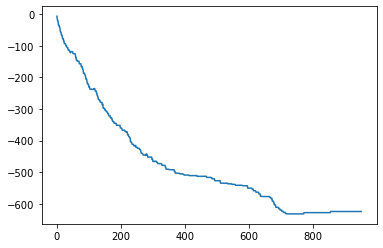

In [478]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)], a_cov_dp.ML_total_history)

In [479]:
len(a_cov_dp.cluster_MLs)

23

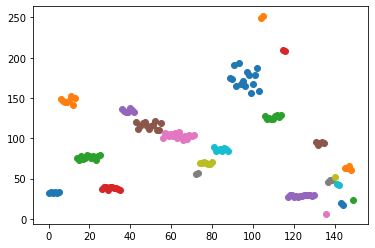

In [480]:
counter=0
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

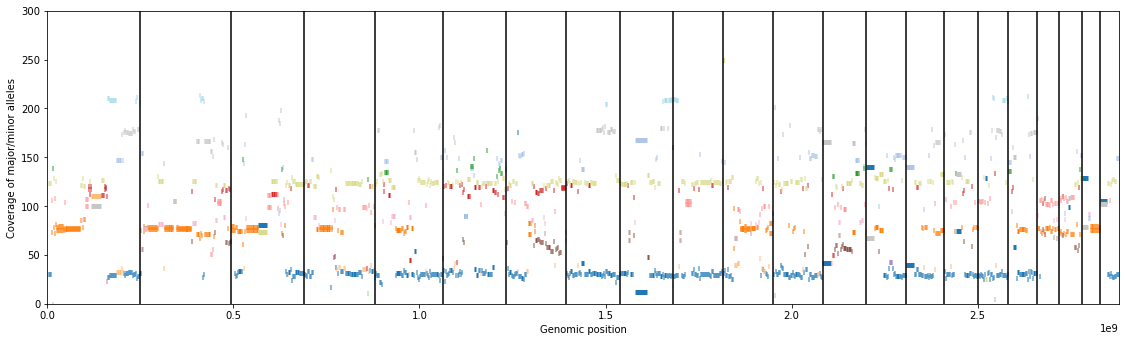

In [482]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(self.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'seg_maj_count', 'seg_min_count']]
        for (_, st, en, cov, allele, major, minor) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

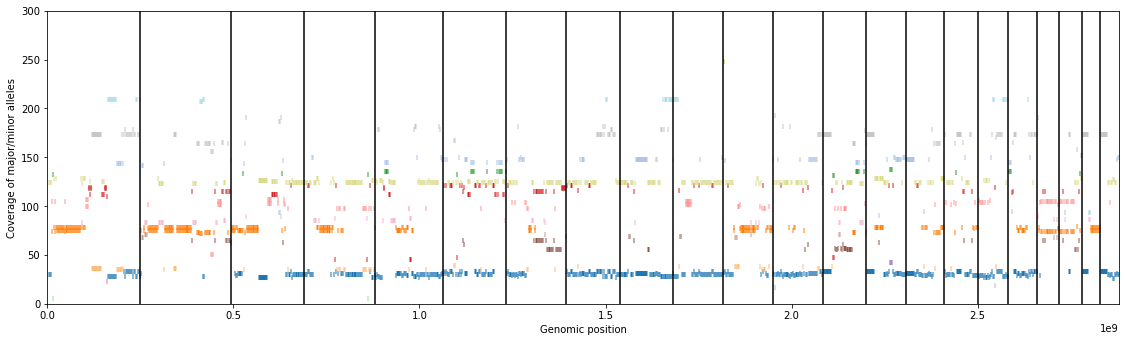

In [481]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(self.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        for (_, st, en, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [499]:
self=a_cov_dp
segID = 1

# get cluster assignment of S
clustID = self.cluster_assignments[segID]
# print('seg_pick:', segID, clustID)
# compute ML of AB = Cs (cached)
if clustID == -1:
    ML_AB = 0
else:
    ML_AB = self.cluster_MLs[clustID]

# compute ML of A = Cs - S
if clustID == -1:
    ML_A = 0
# if cluster is empty without S ML is also 0
elif self.cluster_counts[clustID] == 1:
    ML_A = 0
else:
    ML_A = self._ML_cluster(self.cluster_dict[clustID].difference([segID]))

# compute ML of S on its own
ML_S = self._ML_cluster([segID])

# compute ML of every other cluster C = Ck, k != s (cached)
# for now were also allowing it to chose to stay in current cluster

ML_C = np.array([ML for (ID, ML) in self.cluster_MLs.items()])

# compute ML of every cluster if S joins
ML_BC = np.array([self._ML_cluster(self.cluster_dict[k].union([segID]))
                  for k in self.cluster_counts.keys()])
# likelihood ratios of S joining each other cluster S -> Ck
ML_rat_BC = ML_A + ML_BC - (ML_AB + ML_C)

# if cluster is unassigned we set the ML ratio to 1 for staying in its own cluster
# print(ML_rat_BC)
if clustID > -1:
    ML_rat_BC[list(self.cluster_counts.keys()).index(clustID)] = 0

# compute ML of S starting a new cluster
ML_new = ML_A + ML_S - ML_AB

ML_rat = np.r_[ML_rat_BC, ML_new]

prior_diff = []
clust_prior_p = 1
# use prior cluster information if available

count_prior = np.r_[
    [count_prior[self.prior_clusters.index(x)] for x in
     prior_diff], self.cluster_counts.values(), self.alpha]
count_prior /= count_prior.sum()

# if self.prior_clusters:
# print('count prior: ', count_prior)
# construct transition probability distribution and draw from it
MLs_max = ML_rat.max()
choice_p = np.exp(ML_rat - MLs_max + np.log(count_prior) + np.log(clust_prior_p)) / np.exp(
    ML_rat - MLs_max + np.log(count_prior) + np.log(clust_prior_p)).sum()

In [500]:
def _ML_cluster(self, cluster_set):
    r_lst = []
    V_lst = []
    for s in cluster_set:
        r_seg = self.segment_r_list[s]
        r_lst.append(r_seg)
        V_lst.append(self.segment_V_list[s])
    r = np.hstack(r_lst)
    print(r)
    V = np.hstack(V_lst)
    V_sum = ((V - V.mean())**2).sum()
    alpha = 10
    beta = alpha/2 * 100 * V_sum / len(V)
    print(V_sum)
    print(alpha,beta)
    return self.ML_normalgamma(r, 100, 0.000001, alpha, beta)

In [100]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [101]:
a_cov_dp = dp_a_cov.Run_Cov_DP(tst_res.copy(), dp_pickle.beta)

In [102]:
len(a_cov_dp.cluster_MLs)

1

In [103]:
a_cov_dp.run(1)

n unassigned: 1547
n unassigned: 1437
n unassigned: 1328
n unassigned: 1222
n unassigned: 1135
n unassigned: 1048
n unassigned: 960
n unassigned: 880
n unassigned: 798
n unassigned: 727
n unassigned: 666
n unassigned: 616
n unassigned: 565
n unassigned: 526
n unassigned: 482
n unassigned: 441
n unassigned: 409
n unassigned: 380
n unassigned: 345
n unassigned: 310
n unassigned: 288
n unassigned: 267
n unassigned: 241
n unassigned: 225
n unassigned: 214
n unassigned: 201
n unassigned: 191
n unassigned: 171
n unassigned: 154
n unassigned: 82
n unassigned: 17
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([ 0,  0,  0, ..., 21, 21, 21])],
 SortedDict({0: 261, 1: 45, 2: 68, 3: 36, 4: 198, 6: 282, 7: 75, 9: 71, 11: 57, 12: 35, 13: 190, 15: 8, 17: 121, 20: 39, 21: 16, 22: 9, 23: 12, 24: 15, 25: 3, 26: 8}))

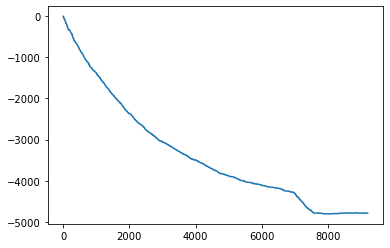

In [104]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)], a_cov_dp.ML_total_history)

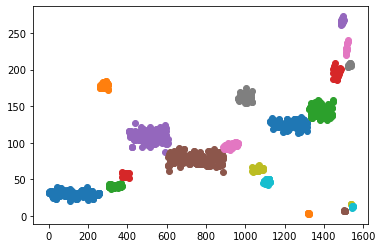

In [105]:
counter=0
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

In [562]:
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    print(c, np.r_[vals].mean())

0 29.723674002579898
2 26.429692811639484
3 200.79648547767812
4 40.00357748536064
5 117.97271786429603
6 101.03249118357095
8 137.3135331599263
9 72.49074781068602
10 164.25252313872275
11 148.60822989406896
12 6.932298314400866
13 46.35716109644864
14 129.0503945097991
15 178.4764505133259
16 34.080057487026274
17 11.190909601284188
18 267.57005596764765
19 23.648831559492344
20 16.216174593114086
22 3.358270788390912
23 225.36735965391915
24 246.71183978514253


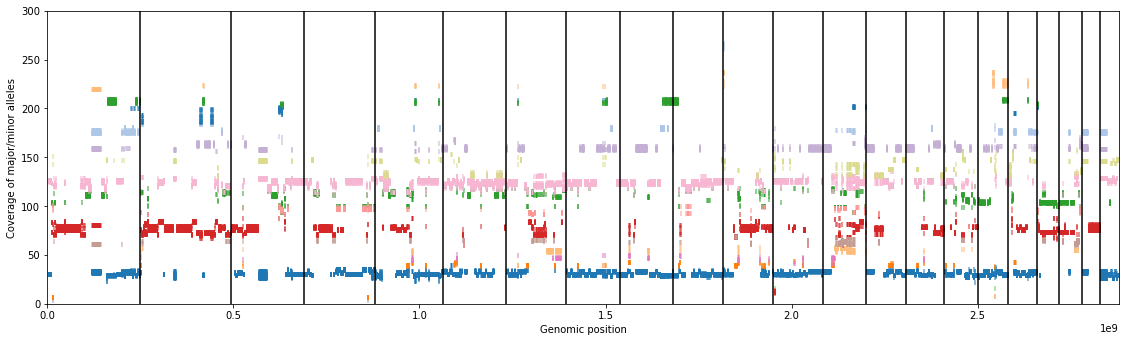

In [109]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(tst_res.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        for (_, st, en, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

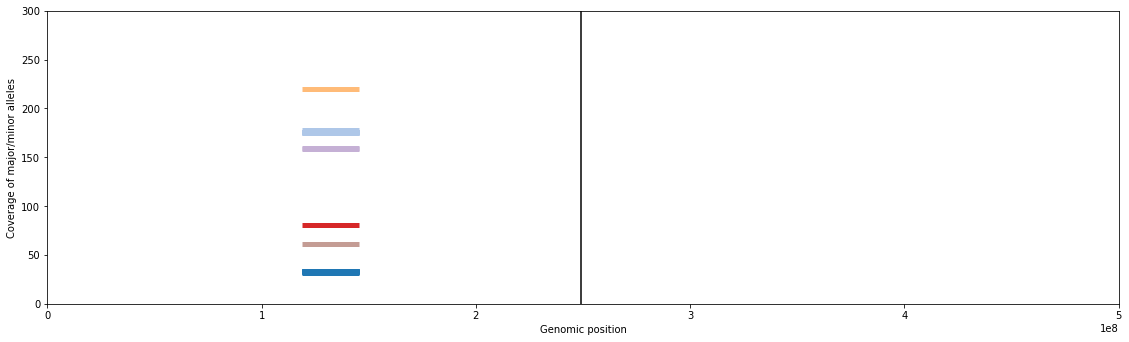

In [139]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(tst_res.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        seg = full_df[s][1]
        x = seg.loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        x = x.loc[(x.start_g > 0.118e9) & (x.start_g < 0.12e9)]
        for (_, st, en, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 0.5e9));
plt.ylim([0, 300]);

In [140]:
tst_res.loc[(tst_res.start_g > 0.118e9) & (tst_res.start_g < 0.12e9)].groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu      maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      2        207.715236   62067.287622   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      8        207.362693   67875.371563   
                                1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      2        207.715236   62067.287622   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      8        207.362693   67875.371563   
                1              -1     3        193.109702  155981.886024   
                                      7        191.331170  146371.243752   
                                1     3        193.109702  155981.886024   
                                      7        191.331170  146371.243752   
                8              -1     4        235.891947    1710.853628   
                                1     4        235.891947    1710.853628   
                11             -1     9        300.591800    1569.173628   
                                1     9        300.591800    1569.173628   

                                                  min_count    len         f  \
allelic_cluster cov_DP_cluster allele dp_draw                                  
0               0              -1     0         6632.547786  187.0  0.155603   
                                      1        14419.431626  187.0  0.160358   
                                      2        11355.669806  187.0  0.154661   
                                      5        11126.001538  187.0  0.154575   
                                      6        14289.861512  187.0  0.161566   
                                      8        12228.638783  187.0  0.152660   
                                1     0         6632.547786  187.0  0.844397   
                                      1        14419.431626  187.0  0.839642   
                                      2        11355.669806  187.0  0.845339   
                                      5        11126.001538  187.0  0.845425   
                                      6        14289.861512  187.0  0.838434   
                                      8        12228.638783  187.0  0.847340   
                1              -1     3        32683.231368  187.0  0.173234   
                                      7        30665.947424  187.0  0.173218   
                                1     3        32683.231368  187.0  0.826766   
                                      7        30665.947424  187.0  0.826782   
                8              -1     4          603.054867  187.0  0.260622   
                                1     4          603.054867  187.0  0.739378   
                11             -1     9          572.450442  187.0  0.267297   
                                1     9          572.450442  187.0  0.732703   

                                                     mu*f  
allelic_cluster cov_DP_cluster allele dp_draw              
0               0              -1     0         32.269297  
                                      1         33.509002  
                                      2         32.125451  
                                      5         32.554123  
                                      6         33.935915  
                                      8         31.655887  
                                1     0        175.112512  
                                      1        175.454973  
                  

In [223]:
tst_chunk = tst_res.loc[(tst_res.allelic_cluster == 0) & (tst_res.cov_DP_cluster==8) & (tst_res.dp_draw == 4)].iloc[-4:]

In [224]:
# ADP 0 CDP 8
tst_chunk

chr      start        end  covcorr  covraw    start_g      end_g  C_len  \
8151   1    1138970    1139348   185857  281995    1138970    1139348    379   
8553   1  109737042  109737216    75093  121748  109737042  109737216    175   
8595   1  118644362  118644549    89796  142793  118644362  118644549    188   
8788   1  198704255  198704381    22367   37477  198704255  198704381    127   

          C_RT    C_RT_z      C_GC    C_GC_z  allelic_cluster  segment_ID  \
8151  0.909914  0.588950  0.704485  0.291114                0           0   
8553  0.881452  0.348692  0.497143  0.018335                0           0   
8595  0.711870 -1.266738  0.457447 -0.046784                0           0   
8788  0.639814 -2.073549  0.409449 -0.133525                0           0   

       min_count   maj_count  cov_DP_cluster  cov_DP_mu  cov_DP_sigma  \
8151   85.692389  406.640000               8   5.463374      0.000038   
8553  223.560000  924.253628               8   5.463374      0.000038   
8595  263.198053  238.280000               8   5.463374      0.000038   
8788   30.604425  141.680000               8   5.463374      0.000038   

         next_g  allele  a_cov_segID  seg_min_count  seg_maj_count  dp_draw  
8151    1147321       1        12272      85.692389     406.640000        4  
8553  109806699       1        12315     223.560000     924.253628        4  
8595  145561095       1        12321     263.198053     238.280000        4  
8788  200143090       1        12340      30.604425     141.680000        4

In [225]:
#looking at corrected coverage for this tuple
np.exp(np.log(tst_chunk['covcorr'].values) - (np.c_[np.log(tst_chunk['C_len']), tst_chunk['C_RT_z'], tst_chunk['C_GC_z']] @ a_cov_dp.beta).flatten())

array([189.641906  , 269.07091865, 330.69530167, 144.33368087])

In [226]:
tst_chunk = tst_res.loc[(tst_res.allelic_cluster == 0) & (tst_res.cov_DP_cluster==11) & (tst_res.dp_draw == 9)].iloc[-3:]

In [227]:
# ADP 0 CDP 11
tst_chunk

chr      start        end  covcorr  covraw    start_g      end_g  C_len  \
8151   1    1138970    1139348   185857  281995    1138970    1139348    379   
8553   1  109737042  109737216    75093  121748  109737042  109737216    175   
8595   1  118644362  118644549    89796  142793  118644362  118644549    188   

          C_RT    C_RT_z      C_GC    C_GC_z  allelic_cluster  segment_ID  \
8151  0.909914  0.588950  0.704485  0.291114                0           0   
8553  0.881452  0.348692  0.497143  0.018335                0           0   
8595  0.711870 -1.266738  0.457447 -0.046784                0           0   

       min_count   maj_count  cov_DP_cluster  cov_DP_mu  cov_DP_sigma  \
8151   85.692389  406.640000              11   5.705753      0.000208   
8553  223.560000  924.253628              11   5.705753      0.000208   
8595  263.198053  238.280000              11   5.705753      0.000208   

         next_g  allele  a_cov_segID  seg_min_count  seg_maj_count  dp_draw  
8151    1147321       1        25905      85.692389     406.640000        9  
8553  109806699       1        25948     223.560000     924.253628        9  
8595  145561095       1        25954     263.198053     238.280000        9

In [228]:
#looking at corrected coverage for this tuple
np.exp(np.log(tst_chunk['covcorr'].values) - (np.c_[np.log(tst_chunk['C_len']), tst_chunk['C_RT_z'], tst_chunk['C_GC_z']] @ a_cov_dp.beta).flatten())

array([189.641906  , 269.07091865, 330.69530167])

(array([ 10.,  47., 142., 257., 248., 198.,  74.,  20.,   3.,   1.]),
 array([54.51035114, 56.0911881 , 57.67202505, 59.252862  , 60.83369895,
        62.41453591, 63.99537286, 65.57620981, 67.15704677, 68.73788372,
        70.31872067]),
 <BarContainer object of 10 artists>)

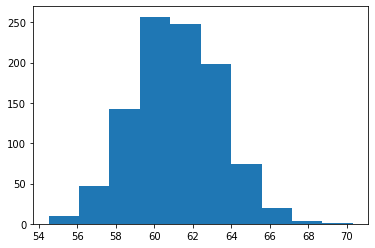

In [149]:
#ADP 0, CDP 8
plt.hist(np.exp(stats.norm.rvs(5.46, 0.000035, size=1000)) * (1- stats.beta.rvs(1710.853628,603.054867, size=1000)))

(array([  6.,  50., 133., 239., 275., 191.,  76.,  24.,   5.,   1.]),
 array([208.30484236, 210.36912515, 212.43340794, 214.49769073,
        216.56197353, 218.62625632, 220.69053911, 222.7548219 ,
        224.81910469, 226.88338748, 228.94767028]),
 <BarContainer object of 10 artists>)

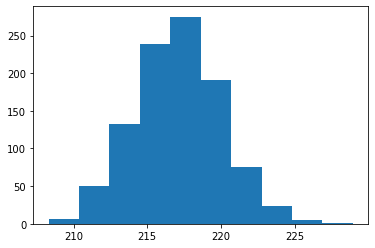

In [155]:
#ADP 0, CDP 11
plt.hist(np.exp(stats.norm.rvs(5.690873, 0.000145, size=1000)) * (stats.beta.rvs(1569,572, size=1000)))

digging into these coverage segments

In [182]:
dp_pickle.DP_runs[4].cluster_dict[8]

SortedSet([0, 10, 12, 24, 60, 65, 69, 72, 74, 77, 78, 86, 88, 90, 143])

In [183]:
dp_pickle.DP_runs[4].cluster_dict

SortedDict({0: SortedSet([1, 5, 20, 35, 47, 51, 95, 101, 105, 124, 135, 141]), 1: SortedSet([4, 6, 29, 37, 49, 92, 94, 99, 119, 122, 127, 131, 136, 138]), 2: SortedSet([8, 15, 21, 53, 63, 67, 75, 84, 104, 108, 109, 111, 140]), 3: SortedSet([7, 14, 30, 39, 42, 45, 59, 61, 64, 66, 73, 76, 85, 87, 89, 103, 121, 128, 129]), 4: SortedSet([18, 23, 26, 32, 44, 50, 55, 58, 71, 132]), 5: SortedSet([9, 11, 16, 19, 25, 27, 100, 110, 113, 115, 116, 118]), 6: SortedSet([43, 83, 91, 102, 112, 126, 133]), 7: SortedSet([17, 46, 54, 56, 68, 81, 96, 107, 130, 134, 139]), 8: SortedSet([0, 10, 12, 24, 60, 65, 69, 72, 74, 77, 78, 86, 88, 90, 143]), 11: SortedSet([13, 28, 48, 57, 79, 80, 82, 93, 98, 137, 142]), 12: SortedSet([3, 22, 34, 38, 40, 52, 62, 97, 106, 114, 117, 123, 125]), 21: SortedSet([70, 120]), 22: SortedSet([2, 31, 33, 36, 41])})

In [190]:
def visualize_DP_run(self, run_idx):
        if run_idx > len(self.DP_runs):
            raise ValueError('DP run index out of range')
        
        cov_dp = self.DP_runs[run_idx]
        cur = 0
        f, axs = plt.subplots(1, figsize = (25,10))
        for c in [8]:
            clust_start = cur
            for seg in cov_dp.cluster_dict[c]:
                len_seg = len(cov_dp.segment_r_list[seg])
                if seg == 0:
                    axs.scatter(np.r_[cur:len_seg+cur], np.exp(np.log(cov_dp.segment_r_list[seg]) - (cov_dp.segment_C_list[seg] @ cov_dp.beta).flatten()), color='k')
                else:
                    axs.scatter(np.r_[cur:len_seg+cur], np.exp(np.log(cov_dp.segment_r_list[seg]) - (cov_dp.segment_C_list[seg] @ cov_dp.beta).flatten()))
                cur += len_seg
                
            axs.add_patch(mpl.patches.Rectangle((clust_start,0), cur-clust_start, 500, fill=True, alpha=0.15, color = colors[c % 10]))

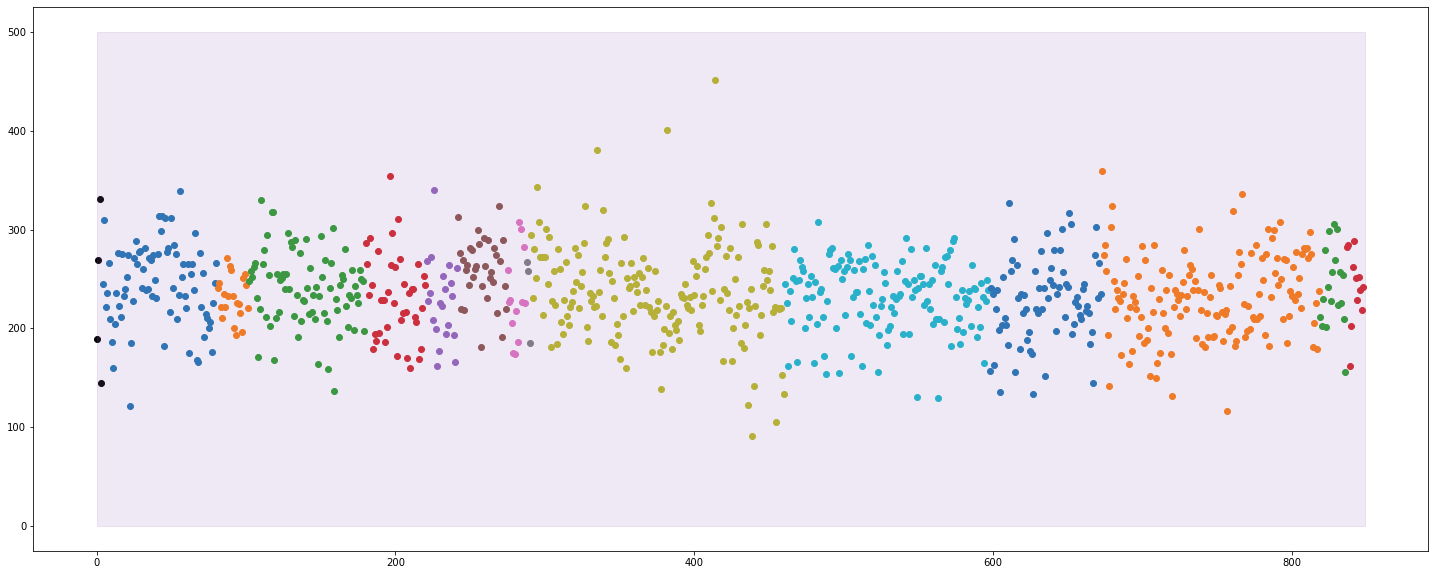

In [191]:
visualize_DP_run(dp_pickle, 4)

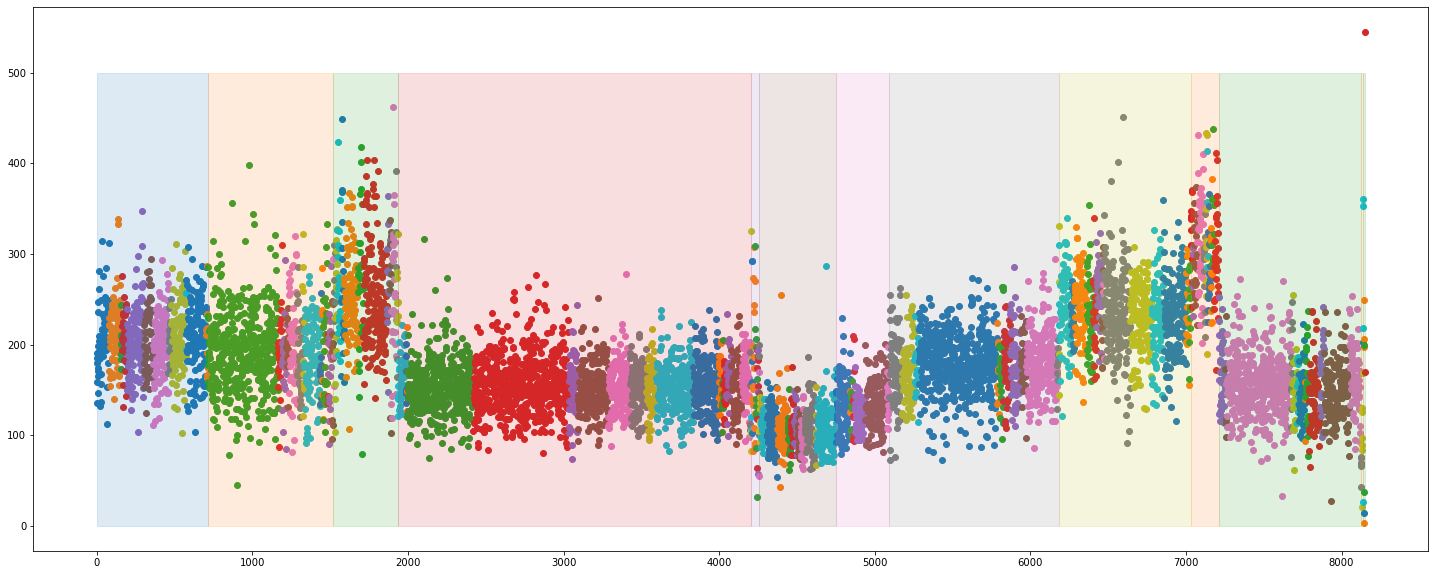

In [185]:
dp_pickle.visualize_DP_run(4, './tst')

In [189]:
dp_pickle.DP_runs[4].cov_df.loc[(dp_pickle.DP_runs[4].cov_df.segment_ID.isin(dp_pickle.DP_runs[4].cluster_dict[8])) & (dp_pickle.DP_runs[4].cov_df.allelic_cluster==0)]

chr      start        end  covcorr  covraw    start_g      end_g  C_len  \
135     1    1138970    1139348   185857  281995    1138970    1139348    379   
10159   1  109737042  109737216    75093  121748  109737042  109737216    175   
11197   1  118644362  118644549    89796  142793  118644362  118644549    188   
16879   1  198704255  198704381    22367   37477  198704255  198704381    127   

           C_RT    C_RT_z      C_GC    C_GC_z  allelic_cluster  segment_ID  
135    0.909914  0.588950  0.704485  0.291114                0           0  
10159  0.881452  0.348692  0.497143  0.018335                0           0  
11197  0.711870 -1.266738  0.457447 -0.046784                0           0  
16879  0.639814 -2.073549  0.409449 -0.133525                0           0

In [239]:
dp_pickle.DP_runs[9].cluster_dict

SortedDict({0: SortedSet([2, 7, 8, 9, 41, 43, 54, 59, 106, 109, 136, 137]), 1: SortedSet([6, 25, 30, 34, 52, 57, 66, 86, 89, 101, 102, 104, 112, 130, 133, 138, 140]), 2: SortedSet([55, 61, 72, 82, 88, 91, 103, 108, 111, 113, 115, 142]), 3: SortedSet([5, 45, 46, 67, 68, 70, 73, 75, 81, 83, 95, 97]), 4: SortedSet([11, 20, 35, 37, 44, 50, 63, 99, 120, 134]), 5: SortedSet([13, 18, 24, 29, 31, 105, 114, 117, 119, 121, 122, 128]), 6: SortedSet([49, 116, 129]), 7: SortedSet([1, 4, 10, 21, 33, 62, 64, 77, 110, 123, 127, 132, 135]), 8: SortedSet([12, 14, 26, 28, 69, 74, 76, 78, 80, 84, 85, 87, 92, 94, 96, 98, 141]), 11: SortedSet([0, 15, 17, 32, 56, 65, 100, 139]), 12: SortedSet([16, 22, 40, 48, 51, 53, 58, 60, 93, 107, 118, 125, 126, 131]), 21: SortedSet([19, 27, 79, 124]), 30: SortedSet([3, 23, 36, 38, 39, 42, 47, 71, 90])})

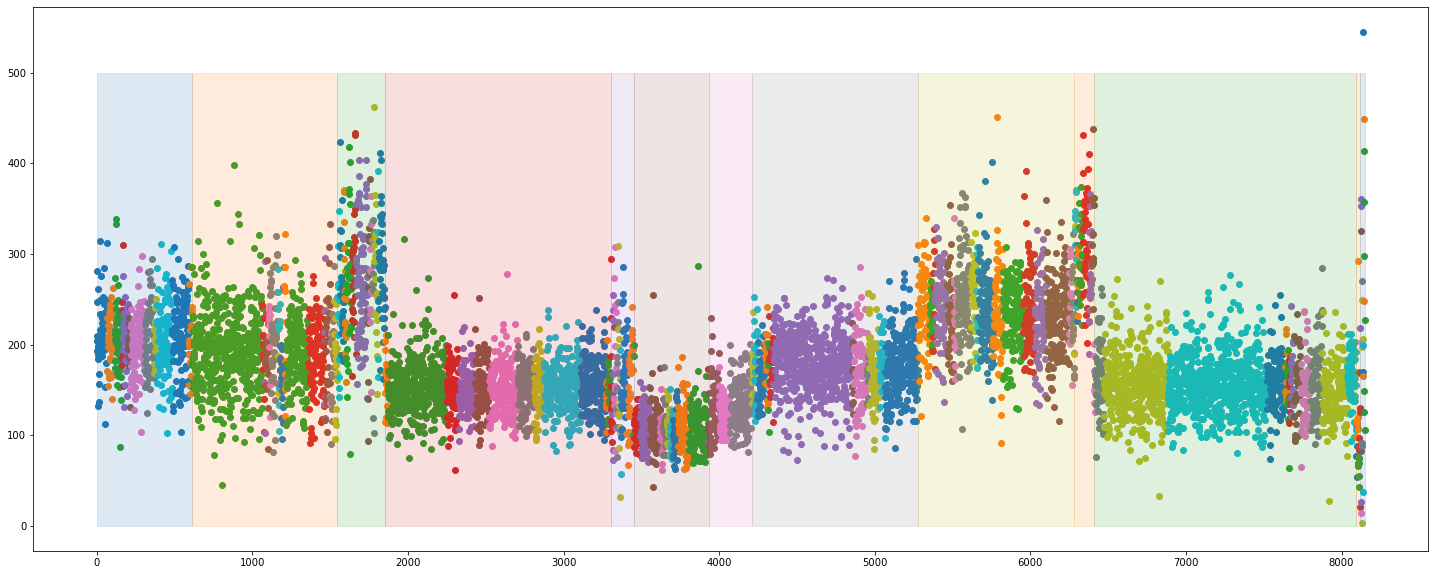

In [238]:
dp_pickle.visualize_DP_run(9, './tst')

In [241]:
def visualize_DP_run(self, run_idx, cluster_num):
        if run_idx > len(self.DP_runs):
            raise ValueError('DP run index out of range')
        
        cov_dp = self.DP_runs[run_idx]
        cur = 0
        f, axs = plt.subplots(1, figsize = (25,10))
        for c in [cluster_num]:
            clust_start = cur
            for seg in cov_dp.cluster_dict[c]:
                len_seg = len(cov_dp.segment_r_list[seg])
                if seg == 0:
                    axs.scatter(np.r_[cur:len_seg+cur], np.exp(np.log(cov_dp.segment_r_list[seg]) - (cov_dp.segment_C_list[seg] @ cov_dp.beta).flatten()), color='k')
                else:
                    axs.scatter(np.r_[cur:len_seg+cur], np.exp(np.log(cov_dp.segment_r_list[seg]) - (cov_dp.segment_C_list[seg] @ cov_dp.beta).flatten()))
                cur += len_seg
                
            axs.add_patch(mpl.patches.Rectangle((clust_start,0), cur-clust_start, 500, fill=True, alpha=0.15, color = colors[c % 10]))

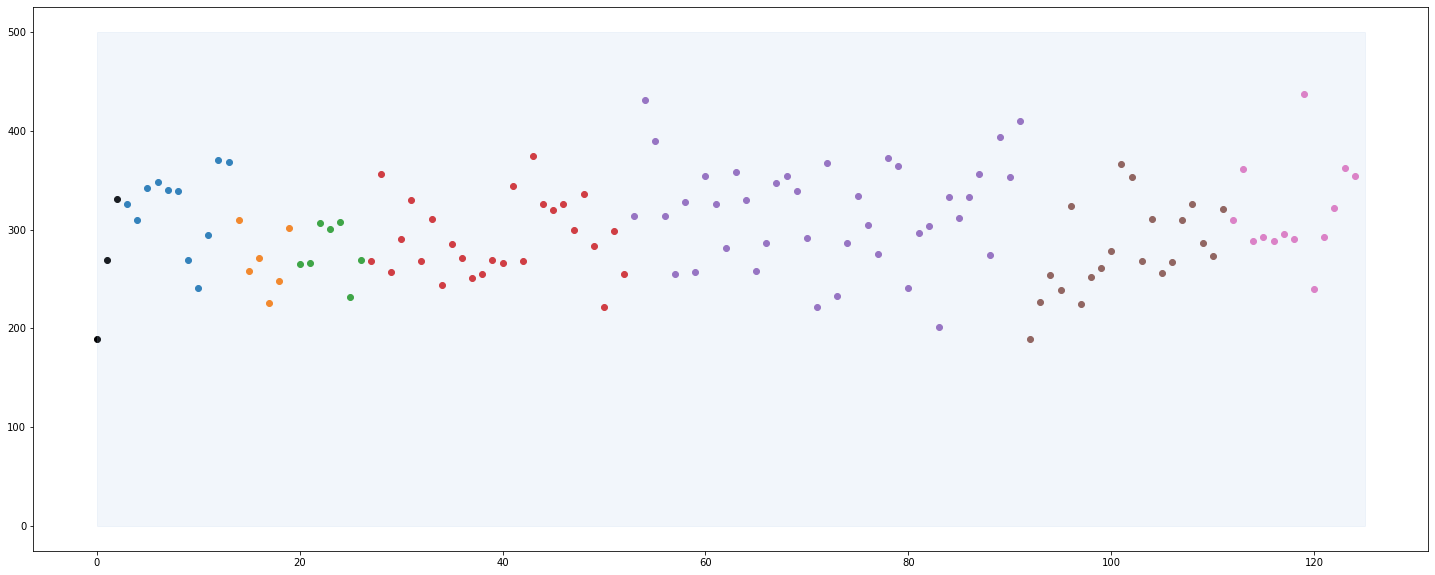

In [244]:
visualize_DP_run(dp_pickle, 9, 11)

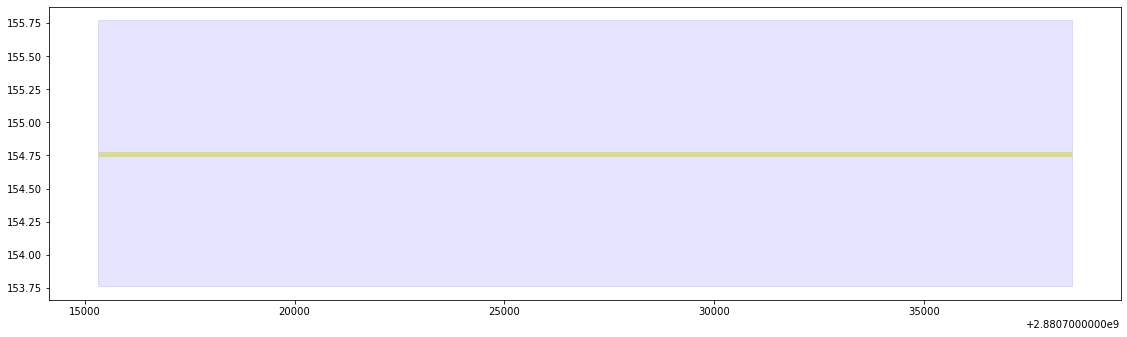

In [702]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
plt.plot(np.r_[2880715315, 2880738523],
        np.exp(5.041893)* np.r_[1,1],
        color = np.array(colors)[c % len(colors)],
        linewidth = 5,
        solid_capstyle = "butt"
            )
plt.fill_between(np.r_[2880715315, 2880738523], np.exp(5.041893 - 1.96*np.sqrt(0.000011)), np.exp(5.041893 + 1.96*np.sqrt(0.000011)), color='b', alpha=.1)

(array([  4.,  24.,  57., 150., 219., 218., 180.,  98.,  37.,  13.]),
 array([147.62402895, 147.74933466, 147.87464038, 147.99994609,
        148.1252518 , 148.25055751, 148.37586322, 148.50116893,
        148.62647464, 148.75178035, 148.87708606]),
 <BarContainer object of 10 artists>)

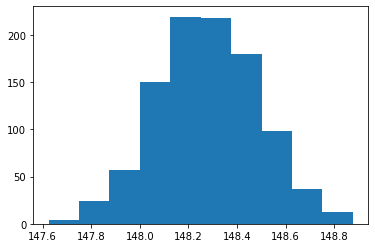

In [36]:
plt.hist(np.exp(stats.norm.rvs(np.log(180), 0.000011, size=1000)) * (stats.beta.rvs(87357,18688, size=1000)))

In [691]:
a_cov_dp.cov_df

chr     start       end  covcorr   covraw     start_g       end_g  \
0       1    984246    984439    72279   110383      984246      984439   
1       1   1138970   1139348   185857   281995     1138970     1139348   
2       1   1147321   1147518    78285   120449     1147321     1147518   
3       1   1469305   1469452    36846    57636     1469305     1469452   
4       1   1956956   1957177    69400   108383     1956956     1957177   
...    ..       ...       ...      ...      ...         ...         ...   
16295  22  50986595  50988380   977681  1456772  2880715315  2880717100   
16296  22  51009803  51009968    59148    93244  2880738523  2880738688   
16297  22  51042269  51043492   635932   981591  2880770989  2880772212   
16298  22  51064006  51064109    40385    64456  2880792726  2880792829   
16299  22  51065593  51065834   104486   159295  2880794313  2880794554   

       C_len      C_RT    C_RT_z  ...  cov_DP_cluster  cov_DP_mu  cov_DP_epsi  \
0        194  1.079453  1.880682  ...               4   5.041893            0   
1        379  0.909914  0.588950  ...               6   5.347871            0   
2        198  0.909914  0.588950  ...               4   5.041893            0   
3        148  0.870065  0.250387  ...               0   5.194456            0   
4        222  1.002400  1.320789  ...               4   5.041893            0   
...      ...       ...       ...  ...             ...        ...          ...   
16295   1786  0.954171  0.948001  ...               0   5.183567            0   
16296    166  1.022385  1.470038  ...               0   5.183567            0   
16297   1224  1.060847  1.749233  ...               0   5.183567            0   
16298    104  1.060847  1.749233  ...               0   5.183567            0   
16299    242  1.060847  1.749233  ...               0   5.183567            0   

       cov_DP_sigma      next_g  allele  a_cov_segID  seg_min_count  \
0          0.000011     1138970      -1            0      69.952971   
1          0.000362     1147321      -1            1      85.692389   
2          0.000011     1469305      -1            2      84.817977   
3          0.000024     1956956      -1            3      59.460025   
4          0.000011     1959593      -1            4     284.018584   
...             ...         ...     ...          ...            ...   
16295      0.000028  2880738523       1        27906    1653.747686   
16296      0.000028  2880770989       1        27906    1653.747686   
16297      0.000028  2880792726       1        27906    1653.747686   
16298      0.000028  2880794313       1        27906    1653.747686   
16299      0.000028  2880794554       1        27906    1653.747686   

       seg_maj_count  dp_draw  
0         290.720000        0  
1         406.640000        0  
2         323.840000        0  
3          97.520000        0  
4        1136.330872        0  
...              ...      ...  
16295    7907.923816        9  
16296    7907.923816        9  
16297    7907.923816        9  
16298    7907.923816        9  
16299    7907.923816        9  

[163000 rows x 26 columns]

In [ ]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        for (_, st, en, cov, sigma, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov) * np.r_[1,1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )
            ci = np.sqrt(sigma) * 1.96
            plt.fill_between(np.r_[st, en], f*np.exp(cov - ci), f*np.exp(cov + ci), color = np.array(colors)[c % len(colors)], alpha=.2)

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

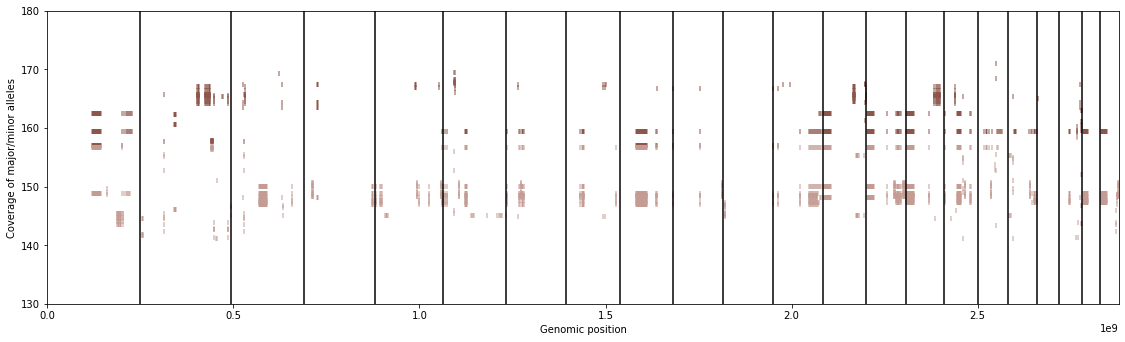

In [610]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in [10,11]:
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        for (_, st, en, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([130, 180]);

In [669]:
tst_res.loc[tst_res.chr ==10].start_g.max()

1815609872

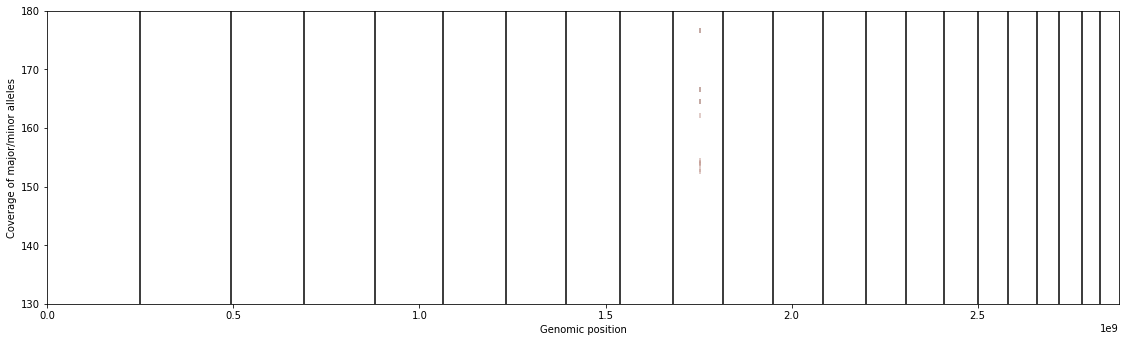

In [670]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in [10,11]:
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        x = x.loc[(x.start_g > 1.68e9) & (x.start_g < 1.8e9)]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        for (_, st, en, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([130, 180]);

In [578]:
pd.set_option('display.max_rows', 500)

In [568]:
a_cov_dp.cluster_dict[11]

SortedSet([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 84, 113, 182, 183, 184, 185, 186, 187, 222, 224, 225, 226, 282, 283, 284, 285, 331, 333, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 460, 463, 464, 465, 500, 507, 636, 646, 647, 648, 649, 650, 651, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 811, 812, 813, 814, 815, 816, 817, 818, 819, 937, 1025, 1026, 1027, 1028, 1159, 1179, 1246, 1247, 1248, 1249, 1299, 1301, 1303, 1446, 1447, 1527, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1697, 1703])

In [71]:
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
accum = pd.DataFrame()
for c in [10, 11]:
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count','dp_draw']]
        accum=accum.append(x)

NameError: name 'a_cov_dp' is not defined

In [673]:
a_cov_dp.cluster_dict[11]

SortedSet([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 84, 113, 182, 183, 184, 185, 186, 187, 222, 224, 225, 226, 282, 283, 284, 285, 331, 333, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 460, 463, 464, 465, 500, 507, 636, 646, 647, 648, 649, 650, 651, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 811, 812, 813, 814, 815, 816, 817, 818, 819, 937, 1025, 1026, 1027, 1028, 1159, 1179, 1246, 1247, 1248, 1249, 1299, 1301, 1303, 1446, 1447, 1527, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1697, 1703])

In [70]:
a_dict = {}
for name, x in full_df:
    maj_count, min_count = x.maj_count.sum(), x.min_count.sum()
    if name[2] == 1:
        f = x.maj_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    else:
        f =x.min_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    a_dict[name] = (maj_count, min_count, f)

NameError: name 'full_df' is not defined

In [677]:
def _tst_fun(x):
    name = (x.allelic_cluster.values[0], x.cov_DP_cluster.values[0], x.allele.values[0],x.dp_draw.values[0])
    maj_count, min_count, f = a_dict[name]
    length = (x.end_g - x.start_g).sum()
    return pd.Series({'DP_mu':np.exp(x.cov_DP_mu.values[0]), 'maj_count':maj_count,  'min_count':min_count, 'len':length, 'f':f,'mu*f':np.exp(x.cov_DP_mu.values[0]) * f})
accum.loc[(accum.start_g > 1.68e9) & (accum.start_g < 1.8e9)].groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu      maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              1      0        180.270034   87357.190216   
                                      2        180.452817   94120.449179   
                                      4        180.010952  143197.594143   
                                      5        179.188477  112258.325303   
                                      6        180.852315  130777.318470   
                                      7        178.661091   86304.720482   
                6              1      1        194.981321   23069.305759   
                                      3        206.915754   13017.398909   
                                      8        189.927243  125594.589093   
                                      9        192.612307  171382.044403   
3               14             1      4        195.847778    1400.240000   
                19             1      6        177.496771    3853.312086   
                                      7        197.813705    2929.569507   
15              0              1      0        180.270034   75051.515980   
                                      1        181.245387   75051.515980   
                                      2        180.452817   75051.515980   
                                      3        179.154583   75051.515980   
                                      4        180.010952   78462.992540   
                                      5        179.188477   75876.903337   
                                      6        180.852315   74922.715980   
                                      7        178.661091   77739.401187   
                                      8        178.203873   74565.755980   
                                      9        178.317794   74565.755980   

                                                  min_count     len         f  \
allelic_cluster cov_DP_cluster allele dp_draw                                   
0               0              1      0        18688.858073  6247.0  0.823767   
                                      2        20143.477819  6247.0  0.823711   
                                      4        30699.334226  6247.0  0.823462   
                                      5        24294.749955  6247.0  0.822086   
                                      6        28009.750991  6247.0  0.823602   
                                      7        18527.721309  6247.0  0.823263   
                6              1      1         5556.008165  6247.0  0.805906   
                                      3         3131.165233  6247.0  0.806103   
                                      8        26657.110434  6247.0  0.824914   
                                      9        35532.586083  6247.0  0.828274   
3               14             1      4          362.881036   513.0  0.794183   
                19             1      6          913.661264   513.0  0.808335   
                                      7          726.383818   513.0  0.801315   
15              0              1      0        15118.120249  3050.0  0.832337   
                                      1        15118.120249  3050.0  0.832337   
                                      2        15118.120249  3050.0  0.832337   
                                      3        15118.120249  3050.0  0.832337   
                                      4        15838.939997  3050.0  0.832040   
                                      5        15305.398201  3050.0  0.832145   
                                      6        15088.390237  3050.0  0.832372   
                                      7        15678.918201  3050.0  0.832164   
                                      8        15016.688442  3050.0  0.832370   
                                      9        15016.688442  3050.0  0.832370   

                                                     mu*f  
allelic_cluster cov_DP_cluster allele dp_draw              
0    

In [589]:
accum.loc[(accum.start_g > 1.5e9) & (accum.next_g < 1.75e9)]

start_g      next_g  allelic_cluster  cov_DP_cluster  cov_DP_mu  \
11676  1536221016  1536490131                0               0   5.194456   
11677  1536490131  1536754862                0               0   5.194456   
11678  1536754862  1536756680                0               0   5.194456   
11679  1536756680  1536790390                0               0   5.194456   
11680  1536790390  1536791369                0               0   5.194456   
11681  1536791369  1537035356                0               0   5.194456   
11682  1537035356  1537035909                0               0   5.194456   
11683  1537035909  1537147256                0               0   5.194456   
11684  1537147256  1537153756                0               0   5.194456   
11685  1537153756  1537173599                0               0   5.194456   
11686  1537173599  1537187927                0               0   5.194456   
11687  1537187927  1537317900                0               0   5.194456   
11704  1538951813  1539374220                0               0   5.194456   
11733  1557841521  1557935452                0               0   5.194456   
11734  1557935452  1557936490                0               0   5.194456   
11796  1579862363  1610159025                0               0   5.194456   
11831  1634227746  1634434004                0               0   5.194456   
11832  1634434004  1634444568                0               0   5.194456   
11833  1634444568  1634564745                0               0   5.194456   
11834  1634564745  1634942310                0               0   5.194456   
11835  1634942310  1634997777                0               0   5.194456   
11836  1634997777  1634999839                0               0   5.194456   
11837  1634999839  1635032561                0               0   5.194456   
11846  1635369604  1635373909                0               0   5.194456   
11847  1635373909  1635398249                0               0   5.194456   
11848  1635398249  1635876917                0               0   5.194456   
11849  1635876917  1637398027                0               0   5.194456   
11884  1651379164  1652058118                0               0   5.194456   
11894  1653519308  1653571444                0               0   5.194456   
11895  1653571444  1654581254                0               0   5.194456   
11896  1654581254  1654811544                0               0   5.194456   
11898  1654978548  1655084740                0               0   5.194456   
11930  1664074235  1664475160                0               0   5.194456   
12015  1676778823  1676846639                0               0   5.194456   
12053  1679516094  1680696407                0               0   5.194456   
12066  1685788826  1685808622                0               0   5.194456   
12067  1685808622  1685810432                0               0   5.194456   
12068  1685810432  1685914103                0               0   5.194456   
12118  1713587941  1714781683                0               0   5.194456   
12148  1741925817  1742314229                0               0   5.194456   
12149  1742314229  1743893763                0               0   5.194456   
11644  1526694382  1527269807                0               0   5.195469   
11645  1527269807  1527283651                0               0   5.195469   
11646  1527283651  1528317551                0               0   5.195469   
11647  1528317551  1528320407                0               0   5.195469   
11648  1528320407  1528409409                0               0   5.195469   
11667  1535253696  1535272198                0               0   5.195469   
11668  1535272198  1535283192                0               0   5.195469   
11669  1535283192  1535284408                0               0   5.195469   
11670  1535284408  1535285699                0               0   5.195469   
11671  1535285699  1535286130                0               0   5.195469   
11672 

In [583]:
for name, group in accum.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']):
    if group.allele.values[0] == 1:
        f = group.maj_count.sum() / (group.maj_count.sum() + group.min_count.sum())
    else:
        f =group.min_count.sum() / (group.maj_count.sum() + group.min_count.sum())
    print(name, np.exp(group.cov_DP_mu.values[0]) * f)

(0, 0, 1, 0) 148.50042876783235
(0, 0, 1, 1) 150.04597176812567
(0, 0, 1, 2) 148.64096361251646
(0, 0, 1, 3) 147.77309031466274
(0, 0, 1, 4) 148.23226330706362
(0, 0, 1, 5) 147.3082779477531
(0, 0, 1, 6) 148.95029450682853
(0, 0, 1, 7) 147.08515105921038
(0, 0, 1, 8) 148.65249835086192
(0, 0, 1, 9) 148.74752815484572
(0, 6, 1, 8) 156.67368020590257
(0, 19, 1, 6) 146.2422810158807
(1, 3, 1, 1) 142.89451455000838
(1, 3, 1, 2) 142.68997465507243
(1, 3, 1, 3) 142.7379098186807
(1, 3, 1, 5) 141.46248289709976
(1, 3, 1, 6) 143.89316530951385
(1, 3, 1, 7) 143.95687885540067
(1, 6, 1, 0) 146.84940157554536
(1, 6, 1, 2) 145.12740980984603
(1, 6, 1, 3) 146.54204052633685
(1, 6, 1, 6) 145.61870474176635
(2, 4, 1, 1) 147.35564862893494
(2, 4, 1, 4) 146.77635795783445
(2, 4, 1, 7) 146.9731381675499
(2, 4, 1, 9) 147.02810936549787
(2, 19, 1, 6) 153.910977552797
(2, 21, 1, 7) 153.01804966646753
(3, 0, 1, 0) 144.56186206955203
(3, 0, 1, 1) 145.55902142791126
(3, 0, 1, 2) 144.76198463215084
(3, 0, 1, 3

In [581]:
accum.loc[accum.dp_draw==0].iloc[300:600]

start_g      next_g  allelic_cluster  cov_DP_cluster  cov_DP_mu  \
16295  2880715315  2880738523                0               0   5.194456   
16296  2880738523  2880770989                0               0   5.194456   
16297  2880770989  2880792726                0               0   5.194456   
16298  2880792726  2880794313                0               0   5.194456   
16299  2880794313  2880794554                0               0   5.194456   
8217     12941674    13695751                1               6   5.347871   
8297     28208481    28564271                1               6   5.347871   
8568    111861741   111861948                1               6   5.347871   
8569    111861948   111862834                1               6   5.347871   
8982    249475484   249522657                1               6   5.347871   
9518    492007997   492811453                1               6   5.347871   
9538    502761808   502829853                1               6   5.347871   
9852    630641198   632617354                1               6   5.347871   
9899    664419043   664496735                1               6   5.347871   
9962    688648683   688731075                1               6   5.347871   
9963    688731075   688836616                1               6   5.347871   
9964    688836616   688885392                1               6   5.347871   
9965    688885392   689062046                1               6   5.347871   
9966    689062046   689124021                1               6   5.347871   
9967    689124021   690907907                1               6   5.347871   
9976    691847091   691849977                1               6   5.347871   
10055   729589202   729679606                1               6   5.347871   
10056   729679606   729688644                1               6   5.347871   
10057   729688644   729774303                1               6   5.347871   
10058   729774303   729920375                1               6   5.347871   
10059   729920375   729922344                1               6   5.347871   
10060   729922344   730394362                1               6   5.347871   
10147   774842359   774846807                1               6   5.347871   
14576  2514151915  2514177298                1               6   5.347871   
14577  2514177298  2514267169                1               6   5.347871   
14777  2561737872  2561745618                1               6   5.347871   
14920  2584543113  2584555819                1               6   5.347871   
8769    184663196   184677286                3               0   5.194456   
8770    184677286   185984290                3               0   5.194456   
8771    185984290   186026365                3               0   5.194456   
8772    186026365   186030982                3               0   5.194456   
8773    186030982   186050338                3               0   5.194456   
8774    186050338   186101459                3               0   5.194456   
8775    186101459   186275449                3               0   5.194456   
8776    186275449   186363078                3               0   5.194456   
8777    186363078   192321176                3               0   5.194456   
8778    192321176   193074646                3               0   5.194456   
8779    193074646   196642107                3               0   5.194456   
8780    196642107   196682864                3               0   5.194456   
8781    196682864   196695599                3               0   5.194456   
8782    196695599   196709748                3               0   5.194456   
8783    196709748   196919981                3               0   5.194456   
8784    196919981   197061036                3               0   5.194456   
8785    197061036   197874925                3               0   5.194456   
8799    201047006   201052289                3               0   5.194456   
8800    201052289   201060767                3               0   5.194456   
8801  

In [574]:
x

start_g      next_g  allelic_cluster  cov_DP_cluster  cov_DP_mu  \
13928  2382936521  2383195467               17               8   5.470322   
13929  2383195467  2383217673               17               8   5.470322   
13930  2383217673  2383255762               17               8   5.470322   
13931  2383255762  2383265335               17               8   5.470322   
13932  2383265335  2383781800               17               8   5.470322   
13939  2385918489  2386111270               17               8   5.470322   
13940  2386111270  2386343705               17               8   5.470322   
13941  2386343705  2386349645               17               8   5.470322   
13942  2386349645  2386374650               17               8   5.470322   
13998  2398188993  2398296400               17               8   5.470322   
14922  2584582005  2584819051               17               8   5.470322   
15882  2763042582  2763078657               17               8   5.470322   
15892  2764959237  2765934866               17               8   5.470322   
15893  2765934866  2766830319               17               8   5.470322   
15894  2766830319  2766832309               17               8   5.470322   
15895  2766832309  2767787421               17               8   5.470322   

       allele   maj_count   min_count  dp_draw  
13928       1  328.778963  146.280000        9  
13929       1  231.840000  114.547990        9  
13930       1  458.160000  227.347155        9  
13931       1  234.342452  131.560000        9  
13932       1  654.724248  319.086245        9  
13939       1  334.025436  156.400000        9  
13940       1  250.240000   85.692389        9  
13941       1  661.480000  369.876334        9  
13942       1  545.560000  273.690999        9  
13998       1  172.040000   91.813274        9  
14922       1  601.595550  293.480000        9  
15882       1  186.760000   99.682984        9  
15892       1  154.560000  104.929456        9  
15893       1  161.000000   81.320329        9  
15894       1  192.370670   92.000000        9  
15895       1  191.496258   89.240000        9

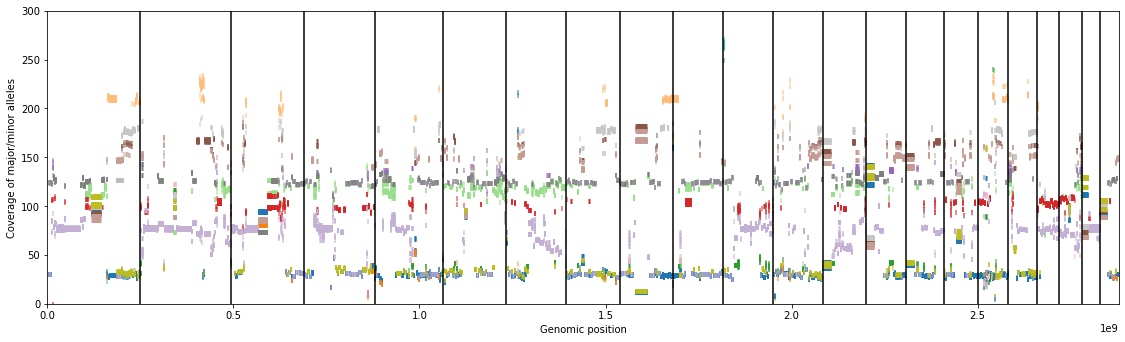

In [558]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(self.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'seg_maj_count', 'seg_min_count']]
        for (_, st, en, cov, allele, major, minor) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [557]:
len(a_cov_dp.cluster_MLs)

22

In [ ]:
a_cov_dp